# ASCAT_CCF calculation in melanoma sample

In [1]:
# Needed basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [3]:
# Import filtered mutation files 
common_mut_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Mel_List_common_mutations_callers.tsv.gz', sep="\t", header=0)

# Import purity value and copy number from ASCAT files
ascat_purity_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/sarek_results/variant_calling/ascat/AB9767_vs_AB9766/AB9767_vs_AB9766.purityploidy.txt', sep="\t", header=0)
ascat_cnv_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/sarek_results/variant_calling/ascat/AB9767_vs_AB9766/AB9767_vs_AB9766.cnvs.txt', sep="\t", header=0)

In [4]:
common_mut_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
0,chr1,59074,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=48,39|5,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:69,0:0.014:69:25,0:38,0:67,0:36,33,0,0",...,69,11,0,18,69,0.379310,SNV,Mutect_Strelka,melanoma,chr1_59074_C_T
1,chr1,60739,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=46,55|4,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:65,0:0.015:65:32,0:30,0:65,0:28,37,0,0",...,65,10,0,36,65,0.217391,SNV,Mutect_Strelka,melanoma,chr1_60739_G_A
2,chr1,86292,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,106|6,4;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:106,0:9.164e-03:106:46,0:41,0:106,0:43,63,0,0",...,106,10,0,75,106,0.117647,SNV,Mutect_Strelka,melanoma,chr1_86292_C_T
3,chr1,108632,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=134,78|7,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.495e-03:153:74,0:73,0:151,0:104,49...",...,153,13,0,59,153,0.180556,SNV,Mutect_Strelka,melanoma,chr1_108632_C_T
4,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:155,0:0:155:4877,0:159,0:0,0,0,0,0,155,1...",...,155,22,0,134,155,0.140000,SNV,Strelka_SAGE,melanoma,chr1_115638_G_A


In [5]:
# Extract purity value from table, note that this value is the Aberrant Cell Fraction
purity = ascat_purity_df['AberrantCellFraction']
purity

0    0.34
Name: AberrantCellFraction, dtype: float64

## 1/ Processing ASCAT CNV file

In [6]:
ascat_cnv_df.head()

,chr,startpos,endpos,nMajor,nMinor
0,1,809641,248916508,1,1
1,2,12091,53062828,2,1
2,2,53063469,56062650,1,1
3,2,56063060,82023937,2,1
4,2,82024043,83680393,1,1


In [7]:
# Calculate copy number (CN) from cnv files and add it as new column (CN is the sum of nMajor and nMinor columns)
ascat_cnv_df[['nMajor', 'nMinor']] = ascat_cnv_df[['nMajor', 'nMinor']].astype(int) # convert so it is operable, not string
ascat_cnv_df['CN'] = ascat_cnv_df['nMajor'] + ascat_cnv_df['nMinor'] # CN is the sum of nMajor and nMinor alleles
ascat_cnv_df.head()

,chr,startpos,endpos,nMajor,nMinor,CN
0,1,809641,248916508,1,1,2
1,2,12091,53062828,2,1,3
2,2,53063469,56062650,1,1,2
3,2,56063060,82023937,2,1,3
4,2,82024043,83680393,1,1,2


In [8]:
# Add "chr" in chr column to homogenize nomenclature as common_mut_df 
ascat_cnv_df['chr'] = ascat_cnv_df['chr'].apply(lambda x: 'chr'+str(x))
ascat_cnv_df.head()

,chr,startpos,endpos,nMajor,nMinor,CN
0,chr1,809641,248916508,1,1,2
1,chr2,12091,53062828,2,1,3
2,chr2,53063469,56062650,1,1,2
3,chr2,56063060,82023937,2,1,3
4,chr2,82024043,83680393,1,1,2


In [9]:
# Rename columns and drop unnecessary columns
ascat_cnv_df = ascat_cnv_df.rename(columns={'chr':'chrom','startpos':'start', 'endpos':'end'})
ascat_cnv_df = ascat_cnv_df.drop(columns=['nMajor','nMinor'])
ascat_cnv_df.head()

,chrom,start,end,CN
0,chr1,809641,248916508,2
1,chr2,12091,53062828,3
2,chr2,53063469,56062650,2
3,chr2,56063060,82023937,3
4,chr2,82024043,83680393,2


## 2/ Add CN from ASCAT CN file to common mutations df with Pybedtools

In [10]:
# Pybedtools package: see https://daler.github.io/pybedtools/main.html for documentation
# installed in the conda environment through terminal with: pip install pybedtools
# The path of BedTools has been modified in bashrc file to be able to execute pybedtools globally.
# Import package
import pybedtools

In [11]:
# To use pybedtools POS column of common_mut_df should have another coordenate like end position. To do so, duplicate the information of POS column and add +1:

mutations_df = pd.DataFrame({
    'CHROM': common_mut_df['CHROM'],
    'start': common_mut_df['POS'],
    'end': common_mut_df['POS'] + 1, # duplicate this column so it is considered a "bed file"
    'REF': common_mut_df['REF'],
    'ALT': common_mut_df['ALT']   
}) # take only necessary columns of common_mut_df to convert as a "bed" coordinate file

mutations_df

,CHROM,start,end,REF,ALT
0,chr1,59074,59075,C,T
1,chr1,60739,60740,G,A
2,chr1,86292,86293,C,T
3,chr1,108632,108633,C,T
4,chr1,115638,115639,G,A
...,...,...,...,...,...
1062268,chrY,56824933,56824934,C,T
1062269,chrY,56825646,56825647,G,A
1062270,chrY,56846085,56846086,C,T
1062271,chrY,56846554,56846555,G,A


### Use ASCAT CNV FILE to intersect with mutation data

In [12]:
# Convert previous dataframes to a BedTool object so data could be processed with pybedtools
mutations_bt = pybedtools.BedTool.from_dataframe(mutations_df)
ascat_cn_bt = pybedtools.BedTool.from_dataframe(ascat_cnv_df)

In [13]:
# Use intersect method of Bedtools to intersect tables (see https://daler.github.io/pybedtools/intersections.html)
cnv_bt = ascat_cn_bt.intersect(mutations_bt) #save intersect table into a new dataframe

In [14]:
# Convert cnv bedtool object into a dataframe. 
cnv_df = cnv_bt.to_dataframe(header=None) # Note that "chrom, start, end, name" columns are by default even using "header = None".
cnv_df

,chrom,start,end,name
0,chr1,825778,825779,2
1,chr1,833950,833951,2
2,chr1,838576,838577,2
3,chr1,840342,840343,2
4,chr1,845674,845675,2
...,...,...,...,...
1057170,chrX,155796973,155796974,2
1057171,chrX,155802120,155802121,2
1057172,chrX,155805334,155805335,2
1057173,chrX,155806379,155806380,2


In [15]:
# Rename columns of cnv dataframe
cnv_df = cnv_df.rename(columns={'chrom':'CHROM','start':'POS','end':'POS2','name':'CN'})

# Drop POS2 column, which is an artificial column we created previously
cnv_df = cnv_df.drop(columns='POS2')

In [16]:
# We are loosing this number of mutations with the intersect method (?!)
len(mutations_df) - len(cnv_df)

5098

## 3/ Calculate CCF

In [17]:
# Merge intersect with common_mut_df adding left indicates: use only keys from left frame, preserve key order
mutations_cnv_df = pd.merge(common_mut_df,cnv_df,how='left')

In [18]:
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
0,chr1,59074,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=48,39|5,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:69,0:0.014:69:25,0:38,0:67,0:36,33,0,0",...,11,0,18,69,0.379310,SNV,Mutect_Strelka,melanoma,chr1_59074_C_T,NaN
1,chr1,60739,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=46,55|4,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:65,0:0.015:65:32,0:30,0:65,0:28,37,0,0",...,10,0,36,65,0.217391,SNV,Mutect_Strelka,melanoma,chr1_60739_G_A,NaN
2,chr1,86292,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,106|6,4;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:106,0:9.164e-03:106:46,0:41,0:106,0:43,63,0,0",...,10,0,75,106,0.117647,SNV,Mutect_Strelka,melanoma,chr1_86292_C_T,NaN
3,chr1,108632,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=134,78|7,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.495e-03:153:74,0:73,0:151,0:104,49...",...,13,0,59,153,0.180556,SNV,Mutect_Strelka,melanoma,chr1_108632_C_T,NaN
4,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:155,0:0:155:4877,0:159,0:0,0,0,0,0,155,1...",...,22,0,134,155,0.140000,SNV,Strelka_SAGE,melanoma,chr1_115638_G_A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062268,chrY,56824933,.,C,T,293,PASS,LPS=428319;LPS_RC=9;RC=TCTTTA;RC_IDX=2;RC_LF=T...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:518,0:0:518:16364,0:539,0:0,0,0,0,0,518,...",...,16,0,399,518,0.039000,SNV,Mutect_SAGE,melanoma,chrY_56824933_C_T,NaN
1062269,chrY,56825646,.,G,A,454,PASS,LPS=428320;LPS_RC=4;RC=GAAAGC;RC_IDX=3;RC_LF=A...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:430,0:0:430:13675,0:443,0:0,0,0,0,0,430,...",...,16,0,362,430,0.042000,SNV,Mutect_SAGE,melanoma,chrY_56825646_G_A,NaN
1062270,chrY,56846085,.,C,T,558,PASS,RC=CTTTG;RC_IDX=2;RC_LF=TTTTTCTACC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:33:599,1:0.001667:600:18877,0:615,0:0,0,1,...",...,21,1,500,599,0.040000,SNV,Mutect_SAGE,melanoma,chrY_56846085_C_T,NaN
1062271,chrY,56846554,.,G,A,305,PASS,RC=AGATG;RC_IDX=2;RC_LF=CTGATCACAC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:9:662,1:0.001508:663:20164,9:683,1:1,0,0,0...",...,14,1,513,662,0.027000,SNV,Mutect_SAGE,melanoma,chrY_56846554_G_A,NaN


In [19]:
# Check in CN column which mutations have non NaN values. Note that returns the same number of rows of cnv_df length.
nan_values = mutations_cnv_df[~mutations_cnv_df['CN'].isna()]
nan_values

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
20,chr1,825778,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=130,129|7,6;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:146,0:6.657e-03:146:82,0:61,0:145,0:76,70,0,0",...,13,0,113,146,0.103175,SNV,Mutect_Strelka,melanoma,chr1_825778_G_A,2.0
21,chr1,833950,.,CC,TT,444,PASS,LPS=8;LPS_RC=17;RC=TGTTTG;RC_IDX=2;RC_LF=GGCAA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:114,0:0:114:3647,0:117,0:0,0,0,0,0,114,1...",...,17,0,115,114,0.129000,MNV,Mutect_SAGE,melanoma,chr1_833950_CC_TT,2.0
22,chr1,838576,.,C,T,526,PASS,LPS=9;LPS_RC=19;RC=GTTTA;RC_IDX=2;RC_LF=CTGTGT...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:130,0:0:130:4151,0:133,0:0,0,0,0,0,130,1...",...,19,0,128,130,0.129000,SNV,Strelka_SAGE,melanoma,chr1_838576_C_T,2.0
23,chr1,840342,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=91,98|11,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:103,0:9.741e-03:103:50,0:48,0:100,0:47,56,0,0",...,17,0,86,103,0.165049,SNV,Mutect_Strelka,melanoma,chr1_840342_C_T,2.0
24,chr1,845674,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=130,118|5,9;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:131,0:7.570e-03:131:55,0:72,0:128,0:70,61,0,0",...,14,0,117,131,0.106870,SNV,Mutect_Strelka,melanoma,chr1_845674_C_T,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058557,chrX,155796973,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,84|3,11;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:97,0:9.856e-03:97:51,0:44,0:97,0:56,41,0,0",...,14,0,92,97,0.132075,SNV,Mutect_Strelka,melanoma,chrX_155796973_C_T,2.0
1058558,chrX,155802120,.,T,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=127,114|6,12;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.139e-03:141:77,0:54,0:138,0:70,71,0,0",...,18,0,100,141,0.152542,SNV,Mutect_Strelka,melanoma,chrX_155802120_T_A,2.0
1058559,chrX,155805334,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=152,138|8,7;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:158,0:6.421e-03:158:77,0:74,0:153,0:77,81,0,0",...,15,0,132,158,0.102041,SNV,Mutect_Strelka,melanoma,chrX_155805334_C_T,2.0
1058560,chrX,155806379,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=108,106|10,6;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:111,0:8.865e-03:111:51,0:58,0:110,0:58,53,0,0",...,16,0,103,111,0.134454,SNV,Mutect_Strelka,melanoma,chrX_155806379_G_A,2.0


In [20]:
# Add 2 in CN with NaN values, because these positions despite were not in the cnv file are diploid
mutations_cnv_df['CN'].fillna(2, inplace=True) 

# Convert columns to float so they are operable to calculate CCF
mutations_cnv_df[['VAF','CN']] = mutations_cnv_df[['VAF','CN']].astype(float)
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
0,chr1,59074,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=48,39|5,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:69,0:0.014:69:25,0:38,0:67,0:36,33,0,0",...,11,0,18,69,0.379310,SNV,Mutect_Strelka,melanoma,chr1_59074_C_T,2.0
1,chr1,60739,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=46,55|4,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:65,0:0.015:65:32,0:30,0:65,0:28,37,0,0",...,10,0,36,65,0.217391,SNV,Mutect_Strelka,melanoma,chr1_60739_G_A,2.0
2,chr1,86292,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,106|6,4;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:106,0:9.164e-03:106:46,0:41,0:106,0:43,63,0,0",...,10,0,75,106,0.117647,SNV,Mutect_Strelka,melanoma,chr1_86292_C_T,2.0
3,chr1,108632,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=134,78|7,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.495e-03:153:74,0:73,0:151,0:104,49...",...,13,0,59,153,0.180556,SNV,Mutect_Strelka,melanoma,chr1_108632_C_T,2.0
4,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:155,0:0:155:4877,0:159,0:0,0,0,0,0,155,1...",...,22,0,134,155,0.140000,SNV,Strelka_SAGE,melanoma,chr1_115638_G_A,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062268,chrY,56824933,.,C,T,293,PASS,LPS=428319;LPS_RC=9;RC=TCTTTA;RC_IDX=2;RC_LF=T...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:518,0:0:518:16364,0:539,0:0,0,0,0,0,518,...",...,16,0,399,518,0.039000,SNV,Mutect_SAGE,melanoma,chrY_56824933_C_T,2.0
1062269,chrY,56825646,.,G,A,454,PASS,LPS=428320;LPS_RC=4;RC=GAAAGC;RC_IDX=3;RC_LF=A...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:430,0:0:430:13675,0:443,0:0,0,0,0,0,430,...",...,16,0,362,430,0.042000,SNV,Mutect_SAGE,melanoma,chrY_56825646_G_A,2.0
1062270,chrY,56846085,.,C,T,558,PASS,RC=CTTTG;RC_IDX=2;RC_LF=TTTTTCTACC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:33:599,1:0.001667:600:18877,0:615,0:0,0,1,...",...,21,1,500,599,0.040000,SNV,Mutect_SAGE,melanoma,chrY_56846085_C_T,2.0
1062271,chrY,56846554,.,G,A,305,PASS,RC=AGATG;RC_IDX=2;RC_LF=CTGATCACAC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:9:662,1:0.001508:663:20164,9:683,1:1,0,0,0...",...,14,1,513,662,0.027000,SNV,Mutect_SAGE,melanoma,chrY_56846554_G_A,2.0


In [21]:
# Define a function that calculates CCF in each row from CN, purity and VAF values
def get_ccf(row):
    row = row['VAF'] * (purity * row['CN'] + (1 - purity) * 2) / purity
    return row

mutations_cnv_df['CCF'] = mutations_cnv_df.progress_apply(get_ccf, axis=1)

  0%|          | 0/1062273 [00:00<?, ?it/s]

In [22]:
mutations_cnv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF
0,chr1,59074,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=48,39|5,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:69,0:0.014:69:25,0:38,0:67,0:36,33,0,0",...,0,18,69,0.379310,SNV,Mutect_Strelka,melanoma,chr1_59074_C_T,2.0,2.231237
1,chr1,60739,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=46,55|4,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:65,0:0.015:65:32,0:30,0:65,0:28,37,0,0",...,0,36,65,0.217391,SNV,Mutect_Strelka,melanoma,chr1_60739_G_A,2.0,1.278772
2,chr1,86292,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,106|6,4;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:106,0:9.164e-03:106:46,0:41,0:106,0:43,63,0,0",...,0,75,106,0.117647,SNV,Mutect_Strelka,melanoma,chr1_86292_C_T,2.0,0.692042
3,chr1,108632,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=134,78|7,6;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.495e-03:153:74,0:73,0:151,0:104,49...",...,0,59,153,0.180556,SNV,Mutect_Strelka,melanoma,chr1_108632_C_T,2.0,1.062092
4,chr1,115638,.,G,A,251,PASS,LPS=4;LPS_RC=22;RC=CAAGT;RC_IDX=2;RC_LF=AAAGTG...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:155,0:0:155:4877,0:159,0:0,0,0,0,0,155,1...",...,0,134,155,0.140000,SNV,Strelka_SAGE,melanoma,chr1_115638_G_A,2.0,0.823529


## 4/ Histograms representing CCF

In [23]:
# To represent in histogram, convert CCF values to list
ccf = mutations_cnv_df['CCF'].copy()  # Extract the 'CCF' column
ccf = pd.to_numeric(ccf, errors='coerce')  # Convert values to numeric, coerce errors
ccf

0          2.231237
1          1.278772
2          0.692042
3          1.062092
4          0.823529
             ...   
1062268    0.229412
1062269    0.247059
1062270    0.235294
1062271    0.158824
1062272    0.670588
Name: CCF, Length: 1062273, dtype: float64

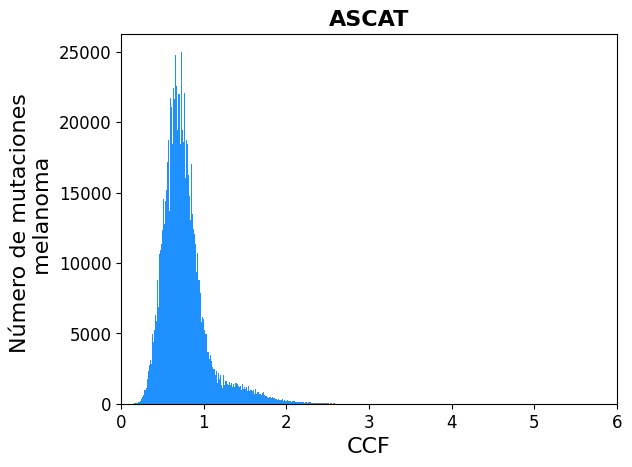

In [24]:
plt.hist(ccf.tolist(), bins = 400, color = 'dodgerblue')
plt.xlim([0,6])
plt.ylabel('Número de mutaciones \n melanoma',  fontsize=16)
plt.xlabel('CCF', fontsize=16)
plt.title('ASCAT', fontsize=16, weight ='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_ccf_ascat_melanoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(ccf.tolist())  